<a href="https://colab.research.google.com/github/fvillena/dcc-ia-nlp/blob/master/6-audio_processing.sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías necesarias

In [ ]:
!pip install python_speech_features
!pip install hmmlearn
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=815a33bbc7517abdb831da2d88c14e6e5f7f0328445180b06a5dc1776932ea3d
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217 kB 5.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 4.6 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=d08fda811d411e566fd5d865c25cfb26d24680827dc94cc24e01b8fcd6211e56
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
S

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa # for working with audio in python
import librosa.display # for waveplots, spectograms, etc
import soundfile as sf # for accessing file information
from librosa.feature import mfcc
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tflearn
import tensorflow as tf


Instructions for updating:
non-resource variables are not supported in the long term


#Base de datos de dígitos
En estas actividades utilizaremos una base de datos de dígitos pronunciados por 25 personas, donde cada persona pronunció 3 veces cada dígito.

Los archivos de tiene la siguiente estructura XLLR.wav
donde X indica el dígito pronunciado, LL el locutor y R la repeteción. 

Ejemplo: 3122.wav corresponde a la segunda pronuncación del dígito 3 por el locutor 12.


Descargar base de datos

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1A-Ab5T1sUu6D29NifSyY16ZYe_6m2Jle' -O digitos.zip
!unzip digitos.zip > /dev/null

--2022-11-24 19:53:01--  https://docs.google.com/uc?export=download&id=1A-Ab5T1sUu6D29NifSyY16ZYe_6m2Jle
Resolving docs.google.com (docs.google.com)... 173.194.210.138, 173.194.210.101, 173.194.210.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.210.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/osueq1j4kq33019rcptt9ve2g0cnqkmd/1669319550000/06230723668430591557/*/1A-Ab5T1sUu6D29NifSyY16ZYe_6m2Jle?e=download&uuid=957f0714-a476-4c15-88bc-00d3f6f3a28e [following]
--2022-11-24 19:53:02--  https://doc-0s-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/osueq1j4kq33019rcptt9ve2g0cnqkmd/1669319550000/06230723668430591557/*/1A-Ab5T1sUu6D29NifSyY16ZYe_6m2Jle?e=download&uuid=957f0714-a476-4c15-88bc-00d3f6f3a28e
Resolving doc-0s-9k-docs.googleusercontent.com (doc-0s-9k-docs.googleusercontent.com)... 173.194.218.132, 2607:

Esta base de datos puede representarse en un dataframe de la siguiente manera.

In [ ]:
database_path = "./digitos/"
filenames = os.listdir(database_path)
df = pd.DataFrame()
df['filename'] = filenames
df['full_filename'] = database_path + df.filename
df['label'] = df.filename.str[0]

### Leer archivo de audio

In [ ]:
wave_file = './digitos/0013.wav'
info = sf.info(wave_file)
x, sample_rate = librosa.load(wave_file, sr=None)
print('Duración:', info.duration, 'secs')
print('Frecuencia de muestreo:', info.duration, 'Hz')
print('Tamaño:', info.frames, 'muestras')

Duración: 0.46820861678004533 secs
Frecuencia de muestreo: 0.46820861678004533 Hz
Tamaño: 5162 muestras


### Visualizar forma de onda

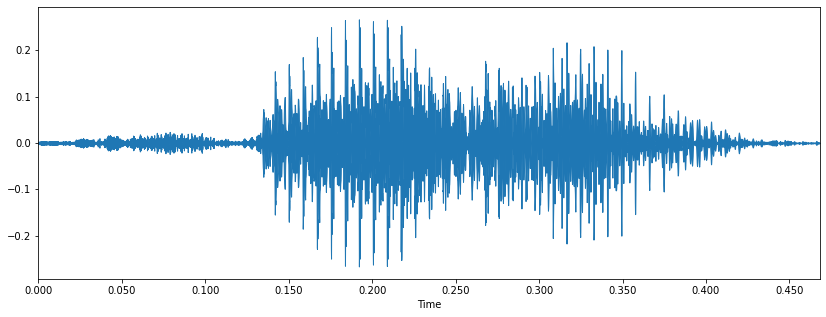

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sample_rate)

### Visualizara espectrograma

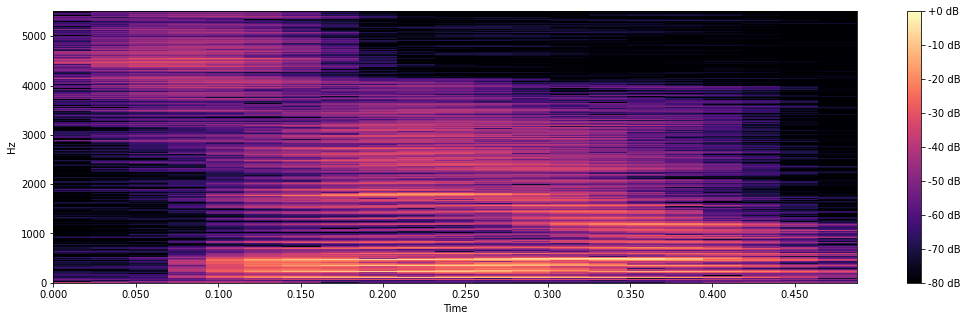

In [ ]:
fig = plt.figure(figsize=(18, 5))
hop_length = 256  # Ventana FFT
D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=hop_length)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', hop_length=hop_length, sr=sample_rate)
fig.colorbar(img, ax=fig.axes, format="%+2.f dB")

# Actividad 1: Comparar espectrogramas
El espectrograma contiene información asociada al tipo de palabra pronunciada.

Palabras diferentes tendrán espectros diferentes. En cambio, los espectros de una misma palabra pronunciada por personas diferentes presentan similitudes.

Si bien estas diferencias y/o similitudes pueden resultar difíciles de identificar mediante la simple inspección de los espectros, estas características pueden ser utilizadas para diferenciar/clasificar palabras.

In [ ]:
# Esta función permite vizualizar los espectrogramas de las señales de audio de entrada
def comparar_espectro(filename1, filename2):
    x1, sample_rate1 = librosa.load(filename1, sr=None)
    x2, sample_rate2 = librosa.load(filename2, sr=None)
    sample_rate = sample_rate1  # Para este caso son iguales

    hop_length = 256  # Ventana FFT
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

    D1 = librosa.amplitude_to_db(np.abs(librosa.stft(x1, hop_length=hop_length)), ref=np.max)
    img = librosa.display.specshow(D1, y_axis='linear', x_axis='time', sr=sample_rate, hop_length=hop_length, ax=ax[0])
    ax[0].label_outer()

    D2 = librosa.amplitude_to_db(np.abs(librosa.stft(x2, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(D2, y_axis='linear', sr=sample_rate, hop_length=hop_length, x_axis='time', ax=ax[1])
    ax[1].label_outer()
    fig.colorbar(img, ax=ax, format="%+2.f dB")

* Visualice y compare los espectros asociados a diferentes pronunciaciones de una misma palabra.
* Realice la misma comparación para pronunciaciones de palabras diferentes
* ¿Qué diferencias/similitudes puede observar?

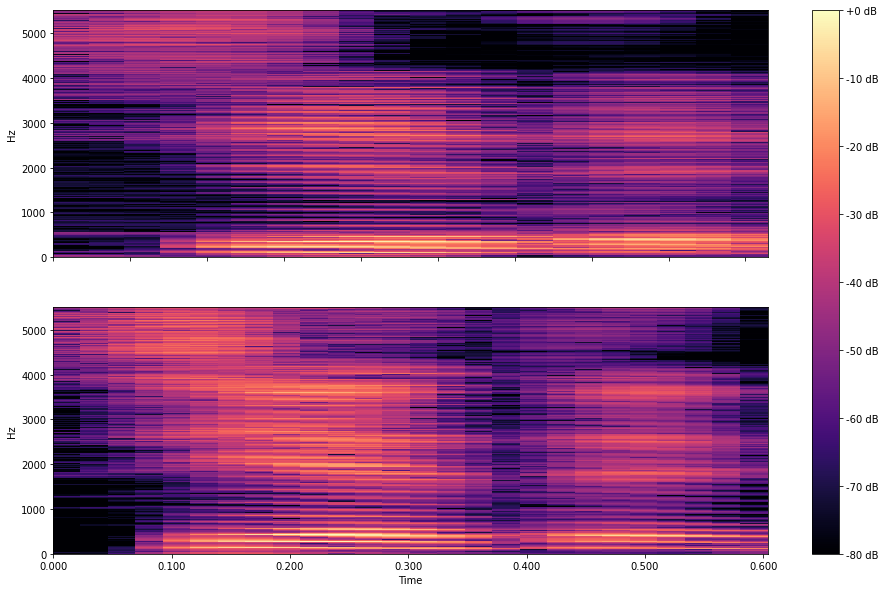

In [ ]:
filename1 = './digitos/7011.wav'
filename2 = './digitos/7101.wav'
comparar_espectro(filename1, filename2)

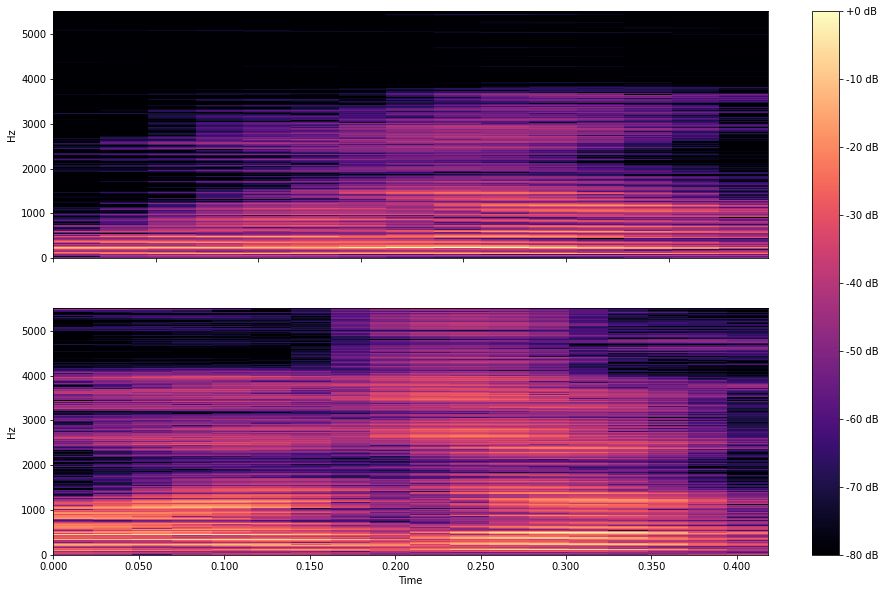

In [ ]:
filename1 = './digitos/1011.wav'
filename2 = './digitos/8011.wav'
comparar_espectro(filename1, filename2)

#Actividad 2: Entrenar un modelo para cada clase en la base de datos

Una representación más compacta del espectro de una señal de voz viene dada por sus parámetros MFCC. Los mismos pueden calcularse utilizando la función *mfcc(signal, sample_rate, n_mfcc, win_length)* donde signal es la señal de audio, sample_rate su frecuencia de muestreo, n_mfcc la cantidad de parámetros a calcular y win_length la ventana utilizada dividir en cuadros la señal
Ejemplo:

*signal, sample_rate = librosa.load('./digitos/0011.wav', sr=None)*

mfcc_features = mfcc(signal, sample_rate, n_mfcc=12, win_length=4*160).T

### 2.1: Crear una función que, a partir de una archivo de audio, calcule sus parámetros MFCC asociados

In [ ]:
def calcular_mfcc(filename):
    signal, sample_rate = librosa.load(filename)
    mfcc_features = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12, win_length=4*160).T
    return mfcc_features

### 2.2: Calcular los MFCC para todas las palabras de la base de datos.
Hint: df['features'] = df.apply(fun, axis=1)


In [ ]:
df['features'] = df.apply(lambda x: calcular_mfcc(x.full_filename), axis=1)

### 2.2: Separar los datos en conjuntos de train y test, manteniendo la misma proporción de clases en ambos conjuntos. Verifique la cantidad de ejemplos en cada subconjunto.

In [ ]:
train_dataset, test_dataset = train_test_split(df, test_size=0.3, stratify=df.label, random_state=333)

### 2.3: Entrenar modelos
Para entrenar los modelos se utiliza la función *hmm.GMMHMM()* de la librería *hmmlearn*. Esta función toma los siguientes parámetros:

* *n_components*: cantidad de estados del modelo
* *n_mix*: cantidad de Gaussianas en cada estado
* *n_iter*: iteraciones máximas para entrenar modelo

Ejemplo:

In [ ]:
states_num = 5
GMM_mix_num = 3
model = hmm.GMMHMM(n_components=states_num, n_mix=GMM_mix_num, n_iter=200)
trainData = train_dataset[train_dataset.label == '0']['features']
trData = np.vstack(trainData)
model.fit(trData)
# Dada una secuencia de features asociadas a una determinada señal de voz, se puede calcular el score asociado al un modelo de la siguiente manera
feature_matrix = test_dataset.iloc[0]['features']
score = model.score(feature_matrix)

* Cree una función que devuelva un diccionario que contenga los modelos entranados para cada en el datos de entrenamiento. Esta función debe tomar como argumentos de entrada el dataframe con datos de entrenamiento, la cantidad de estados y mezclas Gaussiandas que tendrán los modelos

In [ ]:
def entrenar_modelos(train_dataset, states_num, GMM_mix_num):
    hmmModels = {}
    clases = train_dataset.label.unique()
    for label in clases:
        print("Entrenando modelo para", label)
        model = hmm.GMMHMM(n_components=states_num, n_mix=GMM_mix_num, n_iter=200)
        trainData = train_dataset[train_dataset.label == label]['features']
        trData = np.vstack(trainData)
        model.fit(trData)
        hmmModels[label] = model
    return hmmModels

* Entrene los modelos utilizando 5 estados y 3 mezclas Gaussianas

In [ ]:
modelos = entrenar_modelos(train_dataset, 5, 3)

Entrenando modelo para 2
Entrenando modelo para 8
Entrenando modelo para 0
Entrenando modelo para 4
Entrenando modelo para 3
Entrenando modelo para 7
Entrenando modelo para 6
Entrenando modelo para 9
Entrenando modelo para 5
Entrenando modelo para 1


* Calcule el accuracy de los modelos entrenados sobre los datos de test. Para cada ejemplo de: test, calcule el score asociado a cada modelo entrenado y seleccione la clase que tiene mayor score


In [ ]:
test_dataset['pred_label'] = None
for index, row in test_dataset.iterrows():
    feature = row['features']
    scoreList = {}
    for model_label in modelos.keys():
        model = modelos[model_label]
        score = model.score(feature)
        scoreList[model_label] = score
    predict = max(scoreList, key=scoreList.get)
    test_dataset.at[index, 'pred_label'] = predict
accuracy = accuracy_score(test_dataset.label, test_dataset.pred_label)
print("Accuracy", accuracy)

Accuracy 0.8933333333333333


* Entrene modelos con diferentes cantidad de estados y mezclas Gaussianas. ¿Cómo resulta el accuarcy al variar estos parámetros?

#Clasificación usando LSTMM

Necesitamos:
* Entradas de longitud fija
* One-hot encoding

In [ ]:
# Esta función devu
def mfcc_long_fija(mfcc_features, utterance_length):
    mfcc_features = mfcc_features.T
    if mfcc_features.shape[1] > utterance_length:
        mfcc_features = mfcc_features[:, 0:utterance_length]
    else:
        mfcc_features = np.pad(mfcc_features, ((0, 0), (0, utterance_length - mfcc_features.shape[1])),
                               mode='constant', constant_values=0)
    
    return mfcc_features

In [ ]:
# One-hot encode para cada dígito
df['one_hot'] = df.apply(lambda x: np.eye(10)[int(x.label)], axis=1)
utterance_length = 35
df['features_long_fija'] = df.apply(lambda x: mfcc_long_fija(x.features, utterance_length), axis=1)

In [ ]:
# Separamos datos de train, validación y test
train_dataset, test_dataset = train_test_split(df, test_size=0.3, stratify=df.label, random_state=333)
train_dataset2, val_dataset = train_test_split(train_dataset, test_size=0.3, stratify=train_dataset.label)
X_tr = train_dataset2.features_long_fija.to_list() 
y_tr = train_dataset2.one_hot.to_list() 
X_val = val_dataset.features_long_fija.to_list() 
y_val = val_dataset.one_hot.to_list()

In [ ]:
tf.compat.v1.reset_default_graph()
# Parámetros
lr = 0.001
audio_features = 12  
ndigits = 10
# Creamos el modelo
sp_network = tflearn.input_data([None, audio_features, utterance_length], name='input')
sp_network = tflearn.lstm(sp_network, 256*4, dropout=0.5)
sp_network = tflearn.fully_connected(sp_network, ndigits, activation='softmax')
sp_network = tflearn.regression(sp_network, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy')
sp_model = tflearn.DNN(sp_network)

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Entrenamos el modelo
bsize = 32
sp_model.fit(X_tr, y_tr, n_epoch=5, validation_set=(X_val, y_val), show_metric=True, batch_size=bsize)

Training Step: 59  | total loss: 1.12454 | time: 8.244s
| Adam | epoch: 005 | loss: 1.12454 - acc: 0.6475 -- iter: 352/367
Training Step: 60  | total loss: 1.10168 | time: 10.020s
| Adam | epoch: 005 | loss: 1.10168 - acc: 0.6693 | val_loss: 1.09012 - val_acc: 0.5823 -- iter: 367/367
--


## Calculamos accurary sobre test

In [ ]:
test_dataset['pred_label'] = None
for index, row in test_dataset.iterrows():
    feature = row['features_long_fija']
    feature = feature.reshape((1, feature.shape[0], feature.shape[1]))
    prediction_digit = sp_model.predict(feature)
    predict = str(np.argmax(prediction_digit))
    test_dataset.at[index, 'pred_label'] = predict
accuracy = accuracy_score(test_dataset.label, test_dataset.pred_label)
print("Accuracy", accuracy)

Accuracy 0.6222222222222222
